In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')
import string
import nltk
from nltk.corpus import  stopwords
nltk.download('stopwords')
import os
get_ipython().system('pip install wordcloud')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df=pd.read_csv('train_news.csv',index_col='Unnamed: 0')
df.head()

,id,headline,written_by,news,label
0,9653,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0
1,10041,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0
2,19113,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0
3,6868,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0
4,7596,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1


In [3]:
df.isnull().sum()

id               0
headline       558
written_by    1957
news            39
label            0
dtype: int64

In [4]:
print('the shape of dataset:',df.shape)

the shape of dataset: (20800, 5)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          20800 non-null  int64 
 1   headline    20242 non-null  object
 2   written_by  18843 non-null  object
 3   news        20761 non-null  object
 4   label       20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 975.0+ KB


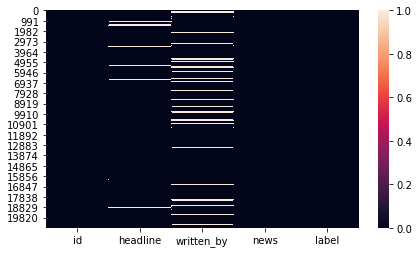

In [6]:
plt.figure(figsize=(7,4))
sns.heatmap(df.isnull())

as we can see there are null value present in our dataset 

In [7]:
df['written_by'].value_counts()

Pam Key                                   243
admin                                     193
Jerome Hudson                             166
Charlie Spiering                          141
John Hayward                              140
                                         ... 
Jonathan Kandell                            1
Willy Wimmer                                1
Jamie Diamond                               1
Rachel L. Swarns and Darcy Eveleigh         1
Michael D. Shear and Matthew Rosenberg      1
Name: written_by, Length: 4201, dtype: int64

most of the news is written by pam key so i am replacing the null values in the written_by with thier mode values.

In [8]:
df['written_by'].fillna(df['written_by'].mode()[0],inplace=True)

In [9]:
df['headline'].fillna(method='ffill',inplace=True)

In [10]:
df['news'].fillna(method='ffill',inplace=True)

In [11]:
df.isnull().sum()

id            0
headline      0
written_by    0
news          0
label         0
dtype: int64

i have used mode values to be replaced by nan values in written_by column.
i have used ffill method to be replaced by nan values in headline and news column to treat the nan values in our dataset.

In [12]:
for column in df.columns:
    if df[column].dtypes==object:
        print(str(column)+ ':' +str(df[column].unique()))
        print(df[column].value_counts())
        print('__________________________________________________')
        print('\n')

headline:['Ethics Questions Dogged Agriculture Nominee as Georgia Governor - The New York Times'
 'U.S. Must Dig Deep to Stop Argentina’s Lionel Messi - The New York Times'
 'Cotton to House: ’Do Not Walk the Plank and Vote for a Bill that Cannot Pass the Senate’ - Breitbart'
 ...
 'Dakota Access Caught Infiltrating Protests to Incite Violence, Funding Trolls Online'
 'How to Stretch the Summer Solstice - The New York Times'
 'Emory University to Pay for ’100 Percent’ of Undocumented Students’ Financial Aid - Breitbart']
“If Trump Loses, I’m Grabbing My Musket”: Former Congressman Ready to Go Full Revolution               5
The Dark Agenda Behind Globalism And Open Borders                                                      5
Get Ready For Civil Unrest: Survey Finds That Most Americans Are Concerned About Election Violence     5
Public vs. Media on War                                                                                4
The U.S. National Bird Is Now a Drone                

In [13]:
df['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

almost both the news values are same but the value of fake news is little on the higher side as compared to the original news.

In [14]:
df['length_headline'] = df.headline.str.len()
df['length_news'] = df.news.str.len()
df.head()

,id,headline,written_by,news,label,length_headline,length_news
0,9653,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0,84,7936
1,10041,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0,72,6112
2,19113,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0,100,425
3,6868,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0,100,6516
4,7596,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1,28,9164


In [15]:
# Replace email addresses with 'email'
df['headline'] = df['headline'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',
                                 'emailaddress')

# Replace URLs with 'webaddress'
df['headline'] = df['headline'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',
                                  'webaddress')

# Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
df['headline'] = df['headline'].str.replace(r'£|\$', 'dollers')

# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
df['headline'] = df['headline'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',
                                  'phonenumber')
# Replace numbers with 'numbr'
df['headline'] = df['headline'].str.replace(r'\d+(\.\d+)?', 'numbr')

# Replace email addresses with 'email'
df['news'] = df['news'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',
                                 'emailaddress')

# Replace URLs with 'webaddress'
df['news'] = df['news'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',
                                  'webaddress')

# Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
df['news'] = df['news'].str.replace(r'£|\$', 'dollers')

# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
df['news'] = df['news'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',
                                  'phonenumber')
# Replace numbers with 'numbr'
df['news'] = df['news'].str.replace(r'\d+(\.\d+)?', 'numbr')

In [16]:
# Remove punctuation
df['headline'] = df['headline'].str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between terms with a single space
df['headline'] = df['headline'].str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
df['headline'] = df['headline'].str.replace(r'^\s+|\s+?$', '')
# Remove punctuation
df['news'] = df['news'].str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between terms with a single space
df['news'] = df['news'].str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
df['news'] = df['news'].str.replace(r'^\s+|\s+?$', '')

In [17]:
stop_words = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])

df['headline'] = df['headline'].apply(lambda x: ' '.join(
    term for term in x.split() if term not in stop_words))

df['news'] = df['news'].apply(lambda x: ' '.join(
    term for term in x.split() if term not in stop_words))

In [18]:
df['clean_length_of_headline'] = df.headline.str.len()
df['clean_length_of_news'] = df.news.str.len()
df.head()

,id,headline,written_by,news,label,length_headline,length_news,clean_length_of_headline,clean_length_of_news
0,9653,Ethics Questions Dogged Agriculture Nominee Ge...,Eric Lipton and Steve Eder,WASHINGTON In Sonny Perdue telling Georgians g...,0,84,7936,79,5711
1,10041,U S Must Dig Deep Stop Argentina Lionel Messi ...,David Waldstein,HOUSTON Venezuela plan It tactical approach de...,0,72,6112,64,4333
2,19113,Cotton House Do Not Walk Plank Vote Bill Canno...,Pam Key,Sunday ABC This Week discussing Republican pla...,0,100,425,69,288
3,6868,Paul LePage Besieged Maine Governor Sends Conf...,Jess Bidgood,AUGUSTA Me The beleaguered Republican governor...,0,100,6516,96,4542
4,7596,A Digital numbr numbr If Trump Wins,Finian Cunningham,Finian Cunningham written extensively internat...,1,28,9164,35,6918


In [19]:
print ('Original Length of headline:', df.length_headline.sum())
print ('Clean Length of headline:', df.clean_length_of_headline.sum())
print ('Original Length of news:', df.length_news.sum())
print ('Clean Length of news:', df.clean_length_of_news.sum())

Original Length of headline: 1545905
Clean Length of headline: 1398980
Original Length of news: 94694016
Clean Length of news: 68069363


# headline as per unclean and clean lenght of headlines column

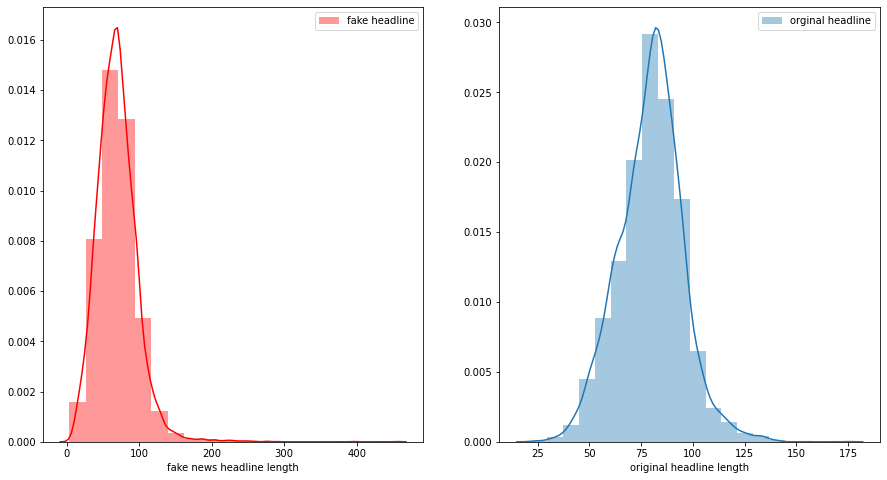

In [20]:
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(df[df['label']==1]['length_headline'],bins=20,ax=ax[0],label='fake headline',color='r')

ax[0].set_xlabel('fake news headline length')
ax[0].legend()

sns.distplot(df[df['label']==0]['length_headline'],bins=20,ax=ax[1],label='orginal headline')
ax[1].set_xlabel('original headline length')
ax[1].legend()

plt.show()

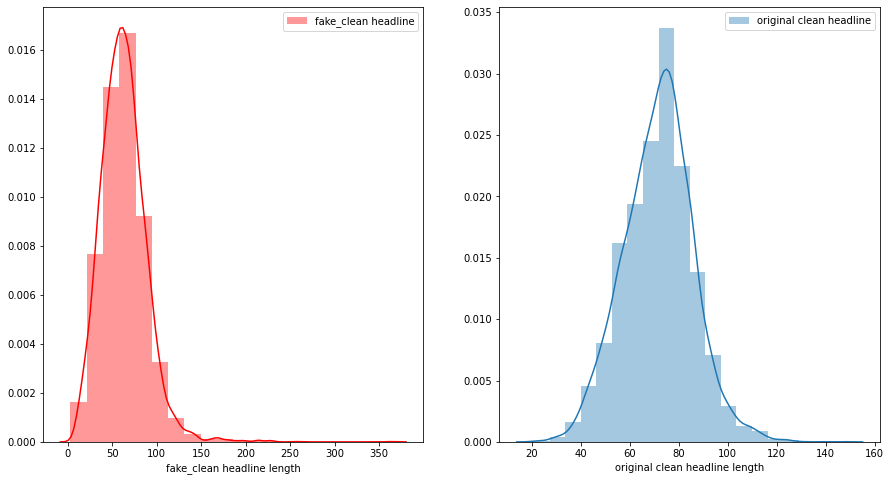

In [21]:
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(df[df['label']==1]['clean_length_of_headline'],bins=20,ax=ax[0],label='fake_clean headline',color='r')

ax[0].set_xlabel('fake_clean headline length')
ax[0].legend()

sns.distplot(df[df['label']==0]['clean_length_of_headline'],bins=20,ax=ax[1],label='original clean headline')
ax[1].set_xlabel('original clean headline length')
ax[1].legend()

plt.show()

# news as per unclean and clean lenght of news columns

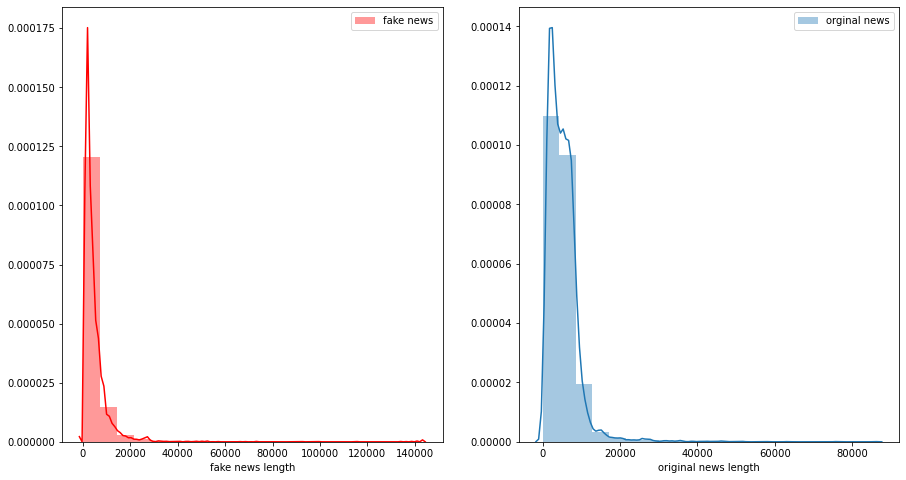

In [22]:
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(df[df['label']==1]['length_news'],bins=20,ax=ax[0],label='fake news',color='r')

ax[0].set_xlabel('fake news length')
ax[0].legend()

sns.distplot(df[df['label']==0]['length_news'],bins=20,ax=ax[1],label='orginal news')
ax[1].set_xlabel('original news length')
ax[1].legend()

plt.show()

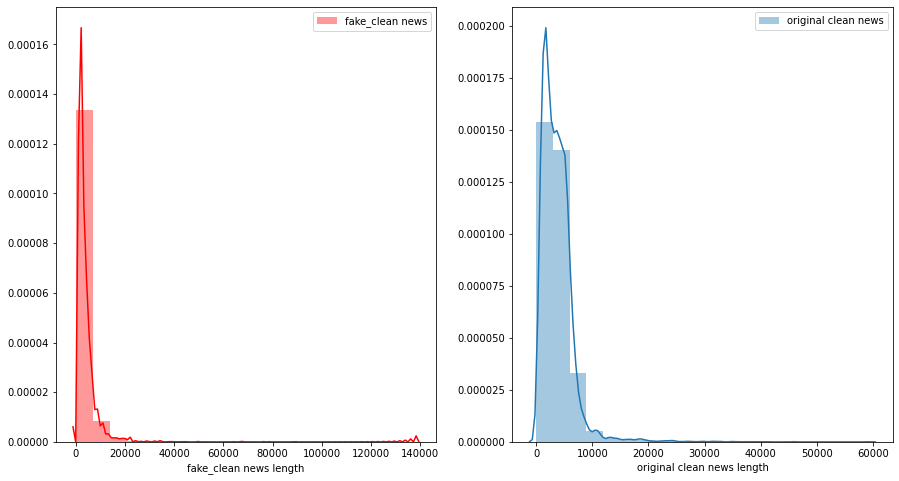

In [23]:
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(df[df['label']==1]['clean_length_of_news'],bins=20,ax=ax[0],label='fake_clean news',color='r')

ax[0].set_xlabel('fake_clean news length')
ax[0].legend()

sns.distplot(df[df['label']==0]['clean_length_of_news'],bins=20,ax=ax[1],label='original clean news')
ax[1].set_xlabel('original clean news length')
ax[1].legend()

plt.show()

# word cloud for fake headline

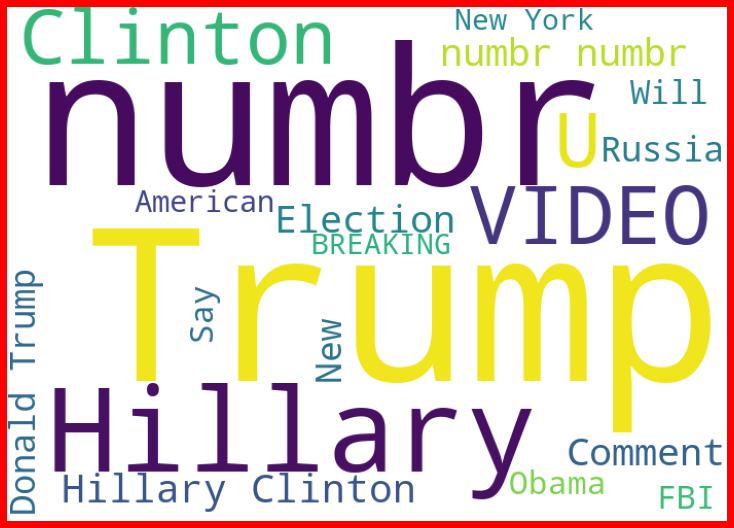

In [24]:
label_1 = df['headline'][df['label']==1]

label1_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(label_1))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(label1_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

# word cloud for original headline

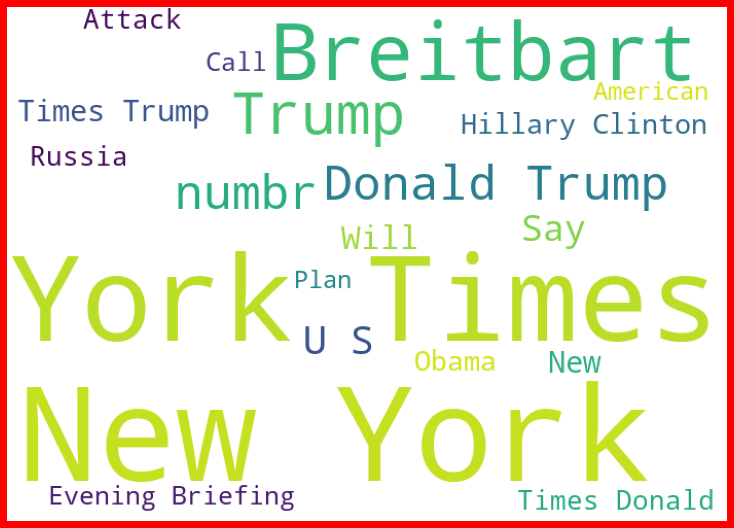

In [25]:
label_0 = df['headline'][df['label']==0]

label0_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(label_0))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(label0_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

# word cloud for fake news

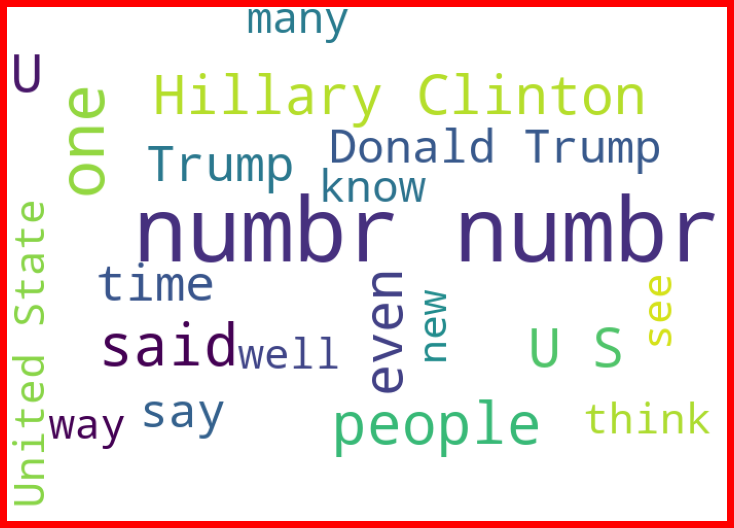

In [26]:
label_1 = df['news'][df['label']==1]

label1_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(label_1))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(label1_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

# word cloud for original news

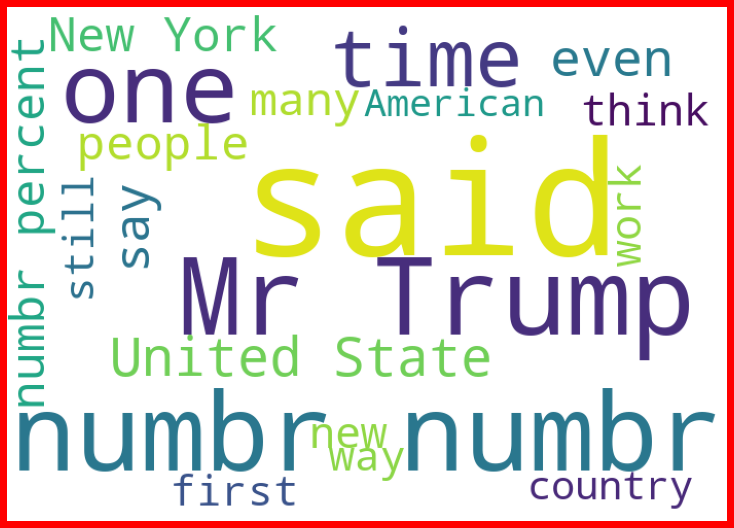

In [27]:
label_0 = df['news'][df['label']==0]

label0_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(label_0))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(label0_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

the value count of fake and original news: 
 1    10413
0    10387
Name: label, dtype: int64


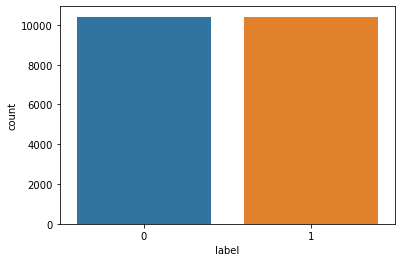

In [28]:
sns.countplot(df['label'])
print('the value count of fake and original news:','\n',df['label'].value_counts())

# buiding the model

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_curve,roc_auc_score,auc
from sklearn.ensemble import GradientBoostingClassifier,BaggingClassifier

vectorizer= TfidfVectorizer()
lg=LogisticRegression()
svc=SVC()
dtc=DecisionTreeClassifier()
knn=KNeighborsClassifier()
naive = MultinomialNB()

feature = vectorizer.fit_transform(df['headline'],df['news'])

x = feature

In [30]:
y=df['label']

# multinomial model

Final score = >  0.8890384615384616
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      2585
           1       0.93      0.84      0.88      2615

    accuracy                           0.89      5200
   macro avg       0.89      0.89      0.89      5200
weighted avg       0.89      0.89      0.89      5200

[[2424  161]
 [ 416 2199]]


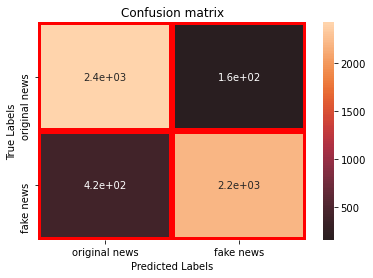

In [31]:
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=42)

naive.fit(x_train,y_train)

y_pred= naive.predict(x_test)

print ('Final score = > ', accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))
conf_mat = confusion_matrix(y_test,y_pred)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='r',center=0)

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['original news','fake news'])
ax.yaxis.set_ticklabels(['original news','fake news'])
print(conf_mat)
plt.show()

# logistics regression model

Final score = >  0.9151923076923076
              precision    recall  f1-score   support

           0       0.97      0.86      0.91      2585
           1       0.87      0.97      0.92      2615

    accuracy                           0.92      5200
   macro avg       0.92      0.91      0.91      5200
weighted avg       0.92      0.92      0.91      5200

[[2216  369]
 [  72 2543]]


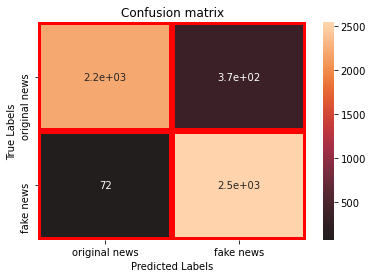

In [32]:
lg.fit(x_train,y_train)

y_pred= lg.predict(x_test)

print ('Final score = > ', accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))
conf_mat = confusion_matrix(y_test,y_pred)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='r',center=0)

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['original news','fake news'])
ax.yaxis.set_ticklabels(['original news','fake news'])
print(conf_mat)
plt.show()

# kneighbors classifier model

Final score = >  0.8167307692307693
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      2585
           1       0.82      0.81      0.82      2615

    accuracy                           0.82      5200
   macro avg       0.82      0.82      0.82      5200
weighted avg       0.82      0.82      0.82      5200

[[2131  454]
 [ 499 2116]]


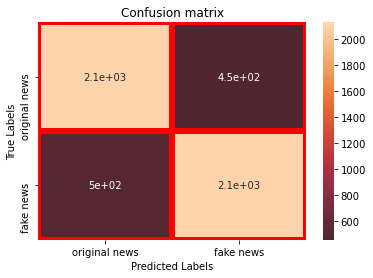

In [33]:
knn.fit(x_train,y_train)

y_pred= knn.predict(x_test)

print ('Final score = > ', accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))
conf_mat = confusion_matrix(y_test,y_pred)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='r',center=0)

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['original news','fake news'])
ax.yaxis.set_ticklabels(['original news','fake news'])
print(conf_mat)
plt.show()

# decision tree classifier model

Final score = >  0.900576923076923
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      2585
           1       0.90      0.91      0.90      2615

    accuracy                           0.90      5200
   macro avg       0.90      0.90      0.90      5200
weighted avg       0.90      0.90      0.90      5200

[[2308  277]
 [ 240 2375]]


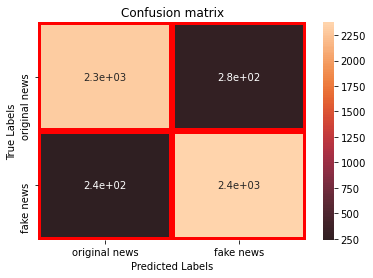

In [34]:
dtc.fit(x_train,y_train)

y_pred= dtc.predict(x_test)

print ('Final score = > ', accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))
conf_mat = confusion_matrix(y_test,y_pred)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='r',center=0)

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['original news','fake news'])
ax.yaxis.set_ticklabels(['original news','fake news'])
print(conf_mat)
plt.show()

Final score = >  0.9113461538461538
              precision    recall  f1-score   support

           0       0.98      0.84      0.90      2585
           1       0.86      0.98      0.92      2615

    accuracy                           0.91      5200
   macro avg       0.92      0.91      0.91      5200
weighted avg       0.92      0.91      0.91      5200

[[2179  406]
 [  55 2560]]


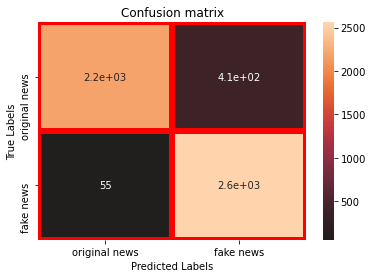

In [35]:
GBC=GradientBoostingClassifier(criterion='friedman_mse',random_state=42,learning_rate=0.1,n_estimators=100,max_depth=4)
BC=BaggingClassifier(n_estimators=100)
GBC.fit(x_train,y_train)

y_pred= GBC.predict(x_test)

print ('Final score = > ', accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))
conf_mat = confusion_matrix(y_test,y_pred)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='r',center=0)

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['original news','fake news'])
ax.yaxis.set_ticklabels(['original news','fake news'])
print(conf_mat)
plt.show()

Final score = >  0.9113461538461538
              precision    recall  f1-score   support

           0       0.98      0.84      0.90      2585
           1       0.86      0.98      0.92      2615

    accuracy                           0.91      5200
   macro avg       0.92      0.91      0.91      5200
weighted avg       0.92      0.91      0.91      5200

[[2179  406]
 [  55 2560]]


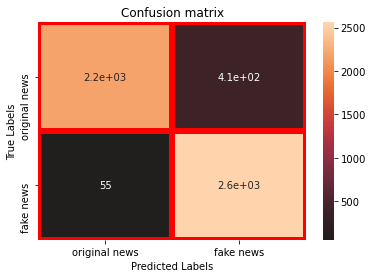

In [36]:
BC.fit(x_train,y_train)

y_pred= GBC.predict(x_test)

print ('Final score = > ', accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))
conf_mat = confusion_matrix(y_test,y_pred)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='r',center=0)

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['original news','fake news'])
ax.yaxis.set_ticklabels(['original news','fake news'])
print(conf_mat)
plt.show()

Final score = >  0.9178846153846154
              precision    recall  f1-score   support

           0       0.94      0.89      0.92      2585
           1       0.90      0.95      0.92      2615

    accuracy                           0.92      5200
   macro avg       0.92      0.92      0.92      5200
weighted avg       0.92      0.92      0.92      5200

[[2300  285]
 [ 142 2473]]


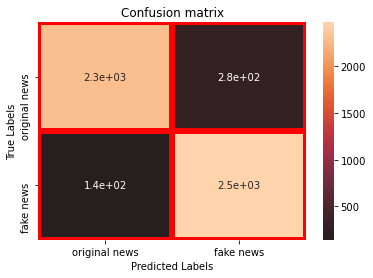

In [37]:
y_pred= BC.predict(x_test)

print ('Final score = > ', accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))
conf_mat = confusion_matrix(y_test,y_pred)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='r',center=0)

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['original news','fake news'])
ax.yaxis.set_ticklabels(['original news','fake news'])
print(conf_mat)
plt.show()